# **Instance Segmentation with YOLO11 Using PanNuke Dataset**

In this notebook, I fine-tune the [YOLO11-seg](https://docs.ultralytics.com/tasks/segment/) model from [Ultralytics](https://www.ultralytics.com/), the latest and most advanced version of the YOLO series for real-time instance segmentation. YOLO11-seg models have been pre-trained on the [COCO](https://docs.ultralytics.com/datasets/detect/coco/#coco-pretrained-models) dataset, which consists of **200,000 images** and **80 object categories**, providing a strong foundation for general instance segmentation tasks.  

In this case, I specifically fine-tune the `YOLO11s-seg` model, which has **10.1 million parameters**. The fine-tuning process is conducted using the [PanNuke](https://arxiv.org/pdf/2003.10778) dataset, designed for instance segmentation and classification of cell nuclei in histopathological images. The raw dataset consists of **7,901 images** extracted from **19 different tissue types**. For this work, I randomly split it into **70% for training, 15% for validation, and 15% for testing**, while maintaining the distribution of cell nuclei by tissue type and class across all three subsets.  

PanNuke includes five classes of cell nuclei: **neoplastic, inflammatory, connective tissue, dead, and non-neoplastic epithelial**. The dataset’s diversity in tissue types, along with the expert-annotated precision, makes it a valuable benchmark for developing and evaluating instance segmentation and classification algorithms in computational pathology. Additionally, it serves as a robust test for assessing the performance of the YOLO model on a dataset entirely unrelated to the one used during its pre-training.  

## **Imports**

In [1]:
# Installation of the Ultralytics library
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
import numpy as np
from PIL import Image
from google.colab import drive
from glob import glob
import imageio.v2 as imageio
import shutil
import yaml
import os

# Necessary in Colab with Ultralytics to prevent path-related encoding errors
import locale
locale.getpreferredencoding = lambda: "UTF-8"

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Mount Google Drive in Colab
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## **Parameters**

In [4]:
model_name = "yolo11s-seg.pt"
zip_dataset_path = "/content/drive/MyDrive/Datasets/PanNuke.zip"
dataset_dir = os.path.basename(zip_dataset_path).split(".")[0]
project_dir = "/content/drive/MyDrive/Ultralytics"
project_name = os.path.join(project_dir, "InstanceSegmentation_YOLO11s_PanNuke")
batch_size = 8
epochs = 50
patience = 7
imgsz = 1024

## **Load the Dataset**

The download, along with all the preprocessing and analysis of the PanNuke, has been completed in the following notebook: [Preprocessing_PanNuke](https://github.com/JersonGB22/ImageSegmentation-TensorFlow-PyTorch/blob/main/Preprocessing/Preprocessing_PanNuke.ipynb).

In [5]:
!unzip -q $zip_dataset_path

## **Training and Evaluation of the Model**

The **YOLO11s-seg** model, downloaded from Ultralytics' GitHub repository, is based on **PyTorch**, which prevents it from being trained on **Google Colab's TPU** to speed up the process.  

One of the advantages of Ultralytics is that there is no need to manually specify the optimizer or learning rate, as these parameters are automatically adjusted based on the dataset size and the number of epochs, which in this case yields the best results.  

It is worth mentioning that I have also experimented with larger models, such as **YOLO11m-seg** and **YOLO11l-seg**, but in this specific fine-tuning scenario with the **PanNuke** dataset, they perform worse than **YOLO11s-seg**. Although larger models usually achieve better results, this is not the case here, and they also significantly increase the fine-tuning time.  

These lower performance results are likely due to the complexity of **PanNuke** images, as the five cell classes are very similar to each other, and the original images have a low resolution (**256 × 256**). For a larger model to generalize properly, it would not only need to address these issues but also increase the number of training images beyond the **5,293 available**, since **YOLO was not pre-trained on medical images**.  

The best results are achieved with **YOLO11s-seg** after **50 epochs** and with an image size of **1024**. Experiments with a higher number of epochs showed that the model tended to stagnate or even degrade in performance on the validation set, negatively impacting its generalization ability.  

Finally, since training YOLO models can be time-consuming, **Ultralytics** offers an option to resume training from where it left off, which is particularly useful in case of interruptions or when exceeding the free usage limit of **Google Colab's GPU**, which has a maximum runtime of **4 hours and 10 minutes**. The total fine-tuning time is approximately **9 hours**.  

Regarding data augmentation to make the model more robust and prevent overfitting, with Ultralytics, it is simply a matter of adjusting the values of each transformation since everything is implemented with the [Albumentations](https://albumentations.ai/), [OpenCV](https://opencv.org/) and [Torchvision](https://pytorch.org/vision/stable/index.html) libraries.

During training, the **YOLO-seg** model uses the following four loss functions::

- **box_loss**: This is the **Complete Intersection over Union (CIoU) Loss**. This loss function considers not only the overlap between the predicted and actual bounding boxes but also the distance between their centers and the aspect ratio. This makes it a more thorough metric for assessing box alignment. It surpasses the performance of IoU (Intersection over Union), GIoU (Generalized IoU), and DIoU (Distance IoU) losses.

- **seg_loss**: This loss function evaluates the accuracy of instance segmentation. The predicted masks are obtained by combining mask coefficients with prototypes, while the ground truth masks are generated from the coordinates of the contours or polygons of the instances, which are then converted into binary masks. The comparison is performed by applying **Binary Cross-Entropy with Logits** on a pixel-by-pixel basis to the masks cropped according to each instance’s bounding box, with the loss normalized by dividing by the corresponding area. This formulation ensures a precise measurement of segmentation errors in delineating object boundaries and separating overlapping instances, preventing errors on small objects from having an excessive impact.

- **cls_loss**: This is the **Binary Cross-Entropy loss with logits** applied to the model's classifier.

- **dfl_loss**: This refers to the **Distribution Focal Loss (DFL)**, an enhanced variant of the focal loss aimed at giving greater emphasis to difficult-to-classify instances. It modifies the focal loss according to the class distribution, enhancing the model's sensitivity to minority classes and helping to address class imbalance.

In [ ]:
pretrained = True
if pretrained:
  model = YOLO(os.path.join(project_name, "weights/last.pt"))
else:
  model = YOLO(model_name)

model.info()

YOLO11s-seg summary: 203 layers, 10,084,223 parameters, 0 gradients, 35.6 GFLOPs


(203, 10084223, 0, 35.6008448)

In [ ]:
if pretrained:
  results = model.train(resume=True)

else:
  results = model.train(
      data=os.path.join(dataset_dir, "val_data.yaml"),
      epochs=epochs,
      patience=patience,
      batch=batch_size,
      imgsz=imgsz,
      deterministic=True, #Allows for reproducibility of the training
      verbose=True,  #Enables model evaluation on the validation dataset immediately after training.
      project=project_dir,
      name=project_name,

      # Data Augmentation
      hsv_h=0.015, #Randomly adjusts the hue of the image within the range [1-0.015; 1+0.015]
      hsv_s=0.2, #Randomly adjusts the saturation of the image within the range [1-0.2; 1+0.2]
      hsv_v=0.3, #Randomly adjusts the brightness of the image within the range [1-0.3; 1+0.3]
      translate=0.1, #Randomly shifts the image horizontally and vertically by up to 10% of its original size
      scale=0.25, #Randomly scales the image size within the range of [100%-25%; 100%+25%]
      fliplr=0.5, #Horizontal flip of the image with a probability of 0.5
      mosaic=1.0, #Combines 4 images into one with a probability of 1
      close_mosaic=10, #Disable mosaic data augmentation in the last 10 epochs
      erasing=0.25 #25% probability of applying random erasure using 'torchvision.transforms.RandomErasing'
  )

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=/content/drive/MyDrive/Ultralytics/InstanceSegmentation_YOLO11s_PanNuke/weights/last.pt, data=PanNuke/val_data.yaml, epochs=50, time=None, patience=7, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Ultralytics, name=InstanceSegmentation_YOLO11s_PanNuke, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/content/drive/MyDrive/Ultralytics/InstanceSegmentation_YOLO11s_PanNuke/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize

100%|██████████| 755k/755k [00:00<00:00, 115MB/s]


TensorBoard: Start with 'tensorboard --logdir /content/drive/MyDrive/Ultralytics/InstanceSegmentation_YOLO11s_PanNuke', view at http://localhost:6006/

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.

100%|██████████| 5.35M/5.35M [00:00<00:00, 250MB/s]


AMP: checks passed ✅


train: Scanning /content/PanNuke/train/labels... 5293 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5293/5293 [00:10<00:00, 501.31it/s]


train: New cache created: /content/PanNuke/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/PanNuke/val/labels... 1128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1128/1128 [00:05<00:00, 210.00it/s]


val: New cache created: /content/PanNuke/val/labels.cache
Plotting labels to /content/drive/MyDrive/Ultralytics/InstanceSegmentation_YOLO11s_PanNuke/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Resuming training /content/drive/MyDrive/Ultralytics/InstanceSegmentation_YOLO11s_PanNuke/weights/last.pt from epoch 46 to 50 total epochs
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Ultralytics/InstanceSegme

      46/50      11.5G      1.102       1.52      0.904      1.156        145       1024: 100%|██████████| 662/662 [09:53<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:52<00:00,  1.36it/s]


                   all       1128      27702      0.652      0.671      0.694      0.455       0.66      0.673        0.7       0.46

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.4G      1.091      1.507     0.8856      1.149        148       1024: 100%|██████████| 662/662 [09:38<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:50<00:00,  1.40it/s]


                   all       1128      27702      0.654      0.683      0.697      0.458       0.66      0.686      0.702      0.462

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      13.8G      1.088      1.498     0.8763      1.142        160       1024: 100%|██████████| 662/662 [09:39<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:48<00:00,  1.46it/s]


                   all       1128      27702      0.658      0.679      0.696      0.457      0.662       0.68      0.699      0.462

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.4G      1.082      1.494      0.869      1.142        166       1024: 100%|██████████| 662/662 [09:40<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:48<00:00,  1.46it/s]


                   all       1128      27702      0.657      0.679      0.694      0.456      0.664      0.682      0.699       0.46

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      14.1G      1.081      1.489     0.8688      1.141        237       1024: 100%|██████████| 662/662 [09:35<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:48<00:00,  1.46it/s]


                   all       1128      27702      0.662      0.677      0.697      0.461      0.665       0.68        0.7      0.464

5 epochs completed in 0.884 hours.
Optimizer stripped from /content/drive/MyDrive/Ultralytics/InstanceSegmentation_YOLO11s_PanNuke/weights/last.pt, 20.6MB
Optimizer stripped from /content/drive/MyDrive/Ultralytics/InstanceSegmentation_YOLO11s_PanNuke/weights/best.pt, 20.6MB

Validating /content/drive/MyDrive/Ultralytics/InstanceSegmentation_YOLO11s_PanNuke/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 113 layers, 10,068,751 parameters, 0 gradients, 35.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]


                   all       1128      27702      0.662      0.677      0.697      0.461      0.666       0.68        0.7      0.464
            neoplastic        622      10947      0.762      0.759      0.814      0.579      0.763      0.758      0.814      0.582
          inflammatory        640       5086      0.708      0.716      0.774      0.541       0.71      0.717      0.774      0.556
            connective        914       7405      0.622      0.619      0.642      0.415      0.632      0.625      0.649      0.412
                  dead         35        472      0.471      0.511      0.448      0.246      0.477      0.517       0.46      0.246
            epithelial        224       3792      0.748      0.781      0.806      0.523      0.749       0.78      0.805      0.525
Speed: 0.8ms preprocess, 17.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/drive/MyDrive/Ultralytics/InstanceSegmentation_YOLO11s_PanNuke


Upon completing the training, Ultralytics automatically evaluates the model's performance on the validation dataset, generating performance metrics and their corresponding graphs. The metrics for instance segmentation are as follows:

- **Precision:** This metric measures the proportion of correct predictions among all predictions made by the model. It is calculated as the number of true positives (TP) divided by the sum of true positives and false positives (FP).

  - **True Positives (TP):** A true positive is counted when the predicted bounding box or segmentation mask has an Intersection over Union (IoU) of at least 0.5 with the ground truth box or mask and belongs to the same class. This means the model has not only correctly detected the presence of an object but has also accurately identified its location, contour, and category.
  
  - **False Positives (FP):** A false positive occurs when the model predicts the presence of an object (i.e., generates a bounding box or segmentation mask), but no corresponding object actually exists in the image, or the detected or segmented object does not belong to the correct class.

  - **False Negatives (FN):** A false negative occurs when the model fails to detect an object that is present in the image. In other words, a real object exists, but the model does not generate any corresponding prediction for it.

- **Recall:** This metric measures the proportion of correctly detected or segmented objects relative to the total number of objects actually present in the image. It is calculated by dividing the number of true positives by the sum of true positives and false negatives.

- **mAP50:** The mean Average Precision at an IoU threshold of 0.5, where Average Precision (AP) is calculated as the area under the precision-recall curve. This metric offers an overall evaluation of the model's ability to detect or segment objects accurately, by averaging precision across various classes, with the IoU threshold fixed at 0.5. It is a standard metric used in the evaluation of the COCO dataset.

- **mAP50-95:** The mean Average Precision across multiple IoU thresholds ranging from 0.5 to 0.95, incremented by 0.05. This metric provides a more comprehensive evaluation of the model's performance, accounting for varying levels of object localization or segmentation precision. Like mAP50, this metric is also used in COCO evaluations, enabling standardized comparisons across different models.

All these metrics range from **0** to **1**, where a value of **0** signifies poor performance (no correct predictions), and a value of **1** represents perfect performance (all predictions are correct).

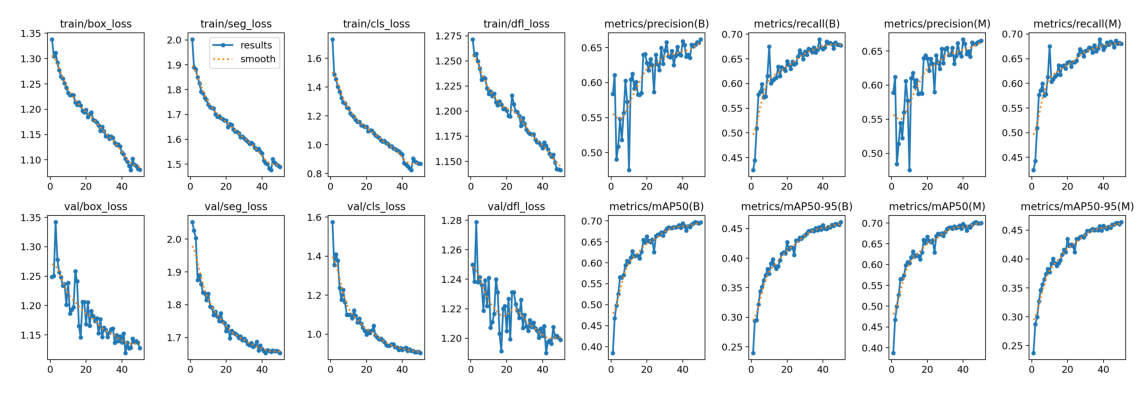

In [ ]:
# Loss and Metrics Graphs
plt.figure(figsize=(12, 8))

img = Image.open(os.path.join(project_name, "results.png"))
plt.imshow(img)
plt.tight_layout()
plt.axis("off");

In [ ]:
# Model evaluation on the test dataset
test_results = model.val(
    data=os.path.join(dataset_dir, "test_data.yaml"),
    name=os.path.join(project_name, "test_eval"),
    batch=batch_size,
    imgsz=imgsz,
    save=True,
    verbose=True,
    exist_ok=True
)

Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/PanNuke/test/labels... 1137 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1137/1137 [00:03<00:00, 318.65it/s]


val: New cache created: /content/PanNuke/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 143/143 [01:04<00:00,  2.22it/s]


                   all       1137      28174      0.642      0.681      0.686       0.45      0.651      0.685      0.692      0.455
            neoplastic        628      12181      0.756      0.773      0.818      0.576      0.761      0.773      0.818      0.578
          inflammatory        609       4132       0.68       0.72      0.756      0.519      0.686       0.72      0.757      0.531
            connective        933       7416      0.616      0.647      0.658      0.426      0.626       0.65      0.664      0.423
                  dead         41        405      0.422      0.484      0.402      0.213      0.439      0.496      0.419      0.225
            epithelial        228       4040      0.735      0.782      0.799      0.516      0.743      0.784        0.8      0.517
Speed: 1.4ms preprocess, 32.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/drive/MyDrive/Ultralytics/InstanceSegmentation_YOLO11s_PanNuke/test_eval


## **Inference with the Trained Model**

Inference with a fine-tuned Ultralytics YOLO model is straightforward, as it accepts a wide range of image and video formats for predictions. Additionally, the results are presented graphically and can be obtained in real time. All accepted formats are detailed in the official [Ultralytics documentation](https://docs.ultralytics.com/modes/predict/#inference-sources).

Additionally, with Ultralytics, it is not necessary to manually generate images with their segmentation masks. However, in this case, for aesthetic purposes and because it is challenging to visually determine whether the cell nucleus predictions are accurate, it is necessary to manually plot the image along with the real and predicted instances.

In [6]:
# Load the trained model
model = YOLO(os.path.join(project_name, "weights/best.pt"))
results_dir = "/content/runs/segment/predict/labels/"

In [7]:
# Extract the class names from the YAML file
with open(os.path.join(dataset_dir, "val_data.yaml"), "r") as archivo:
    metadata = yaml.safe_load(archivo)

class_names = metadata["names"]
class_colors = metadata["colors"]
print(class_names)

{0: 'neoplastic', 1: 'inflammatory', 2: 'connective', 3: 'dead', 4: 'epithelial'}


In [56]:
# Function to draw instance segmentation annotations on an axis
def draw_annotations(ax, labels, width, height, class_colors, class_names, title, with_conf):
  ax.set_title(title, fontsize=8.5, fontweight="bold")
  ax.axis("off")

  for label in labels:
    cls = int(label[0]) # Extract class index
    color = np.array(class_colors[cls]) / 255

    # Reshape contour points and scale them to image dimensions
    if with_conf:
      contour = np.array(label[1:-1]).reshape(-1, 2).astype(np.float32)
      conf = float(label[-1]) # Extract confidence scores
    else:
      contour = np.array(label[1:]).reshape(-1, 2).astype(np.float32)

    contour[:, 0] *= width
    contour[:, 1] *= height

    # Draw filled polygon with transparency
    polygon = patches.Polygon(contour, facecolor=color, edgecolor=color, alpha=0.4, linewidth=1.5)
    ax.add_patch(polygon)

    # Draw bounding box around the instance
    xmin, ymin = contour.min(axis=0)
    xmax, ymax = contour.max(axis=0)
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1.5, edgecolor=color, facecolor="none")
    ax.add_patch(rect)

    # Adjust text positioning to prevent overlap with image boundaries
    text_x, ha = (xmin, "left") if xmax < (0.85 * width) else (xmax, "right")
    text_y, va = (ymin, "bottom") if ymin > (0.15 * height) else (ymax, "top")

    # Display class name
    name = f"{class_names[cls]} {conf:.2f}" if with_conf else f"{class_names[cls]}"
    ax.text(
        text_x, text_y, name,
        color="black", fontsize=7, fontweight="bold", ha=ha, va=va,
        bbox={"boxstyle": "square,pad=0", "facecolor": color, "edgecolor": color, "alpha": 0.7}
    )


# Function to visualize instance segmentation and save the results
def instance_segmentation(images, n_rows=2, random=True, save=True, save_dir="images"):
  # Ensure save directory exists
  os.makedirs(save_dir, exist_ok=True)

  # Select images randomly or sequentially based on `random` flag
  sample_images = np.random.choice(images, n_rows, replace=False).tolist() if random else images[:n_rows]

  # Run YOLO model inference on selected images
  results = model.predict(
      source=sample_images,
      batch=batch_size,
      imgsz=imgsz,
      save=False,
      save_txt=True,
      save_conf=True,
      verbose=False
  )
  clear_output(wait=False) # Clear console output for cleaner display

  fig, axes = plt.subplots(n_rows, 2, figsize=(9.6, n_rows * 4.8))

  for img_path, (ax_true, ax_pred) in zip(sample_images, axes):
    image = Image.open(img_path)
    width, height = image.size

    # Extract tissue type from file name
    tissue = os.path.basename(img_path).split("_")[0].replace("-", " ")

    # Load ground truth labels
    label_path = img_path.replace(".png", ".txt").replace("images", "labels")
    with open(label_path, "r") as file:
      labels = [row.split() for row in file.readlines()]

    # Load predicted labels from results
    with open(os.path.join(results_dir, os.path.basename(label_path)), "r") as file:
      labels_pred = [row.split() for row in file.readlines()]

    # Display original image
    ax_true.imshow(image)
    ax_pred.imshow(image)

    # Draw annotations for ground truth and predictions
    draw_annotations(ax_true, labels, width, height, class_colors, class_names, f"{tissue} (True)", with_conf=False)
    draw_annotations(ax_pred, labels_pred, width, height, class_colors, class_names, f"{tissue} (Pred)", with_conf=True)

  plt.tight_layout()

  # Save the figure, if configured
  if save:
    plt.savefig(os.path.join(save_dir, f"{len(os.listdir(save_dir))}.png"))

  plt.show()

  # Remove temporary result files
  shutil.rmtree(results_dir)

### **Validation Dataset**

In [ ]:
val_image_paths = glob(os.path.join(dataset_dir, "val/images/*.png"))

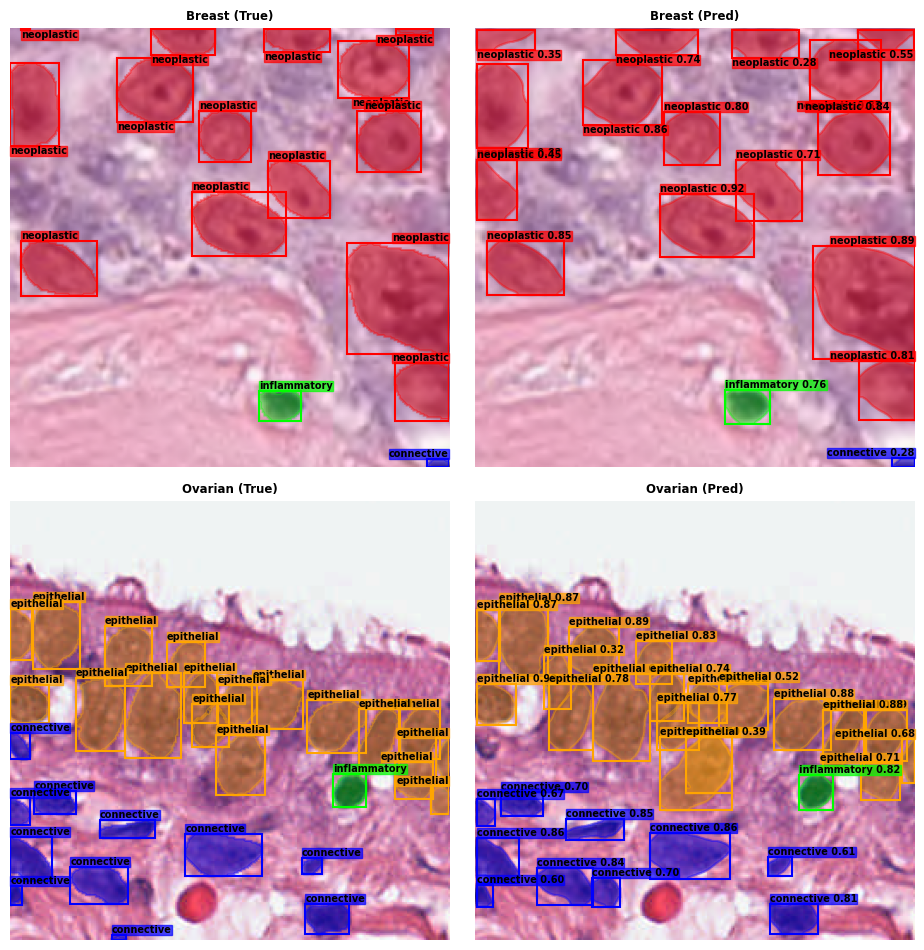

In [45]:
instance_segmentation(val_image_paths)

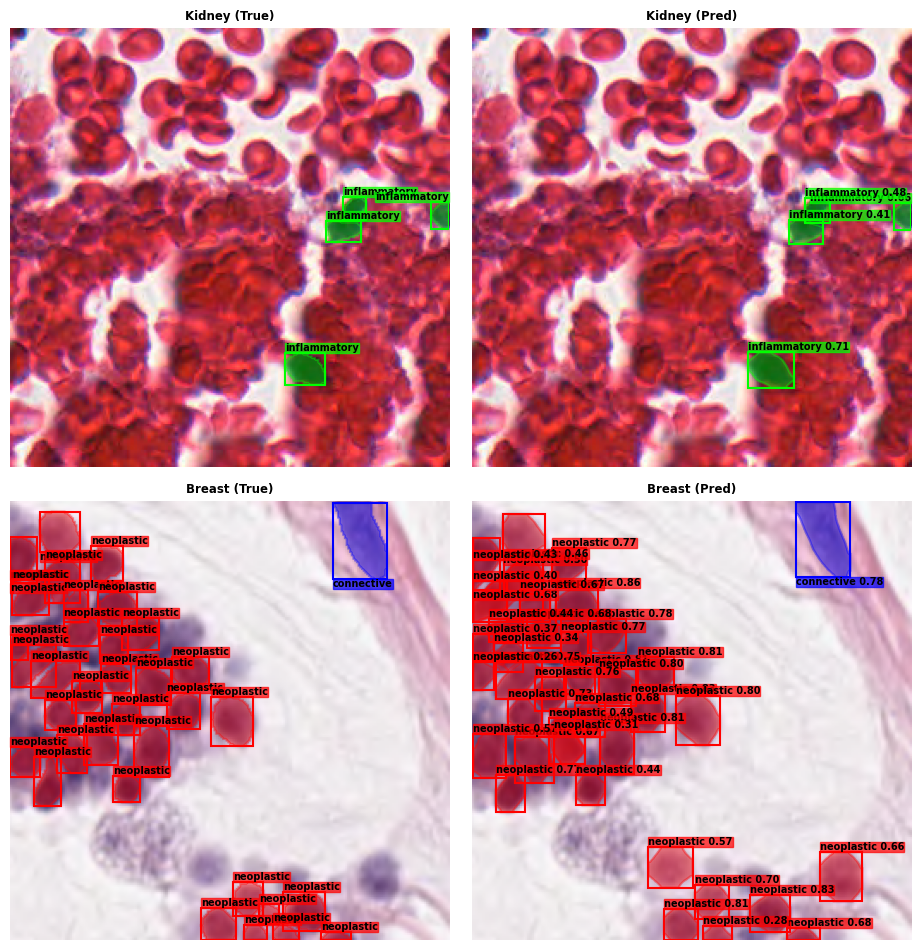

In [46]:
instance_segmentation(val_image_paths)

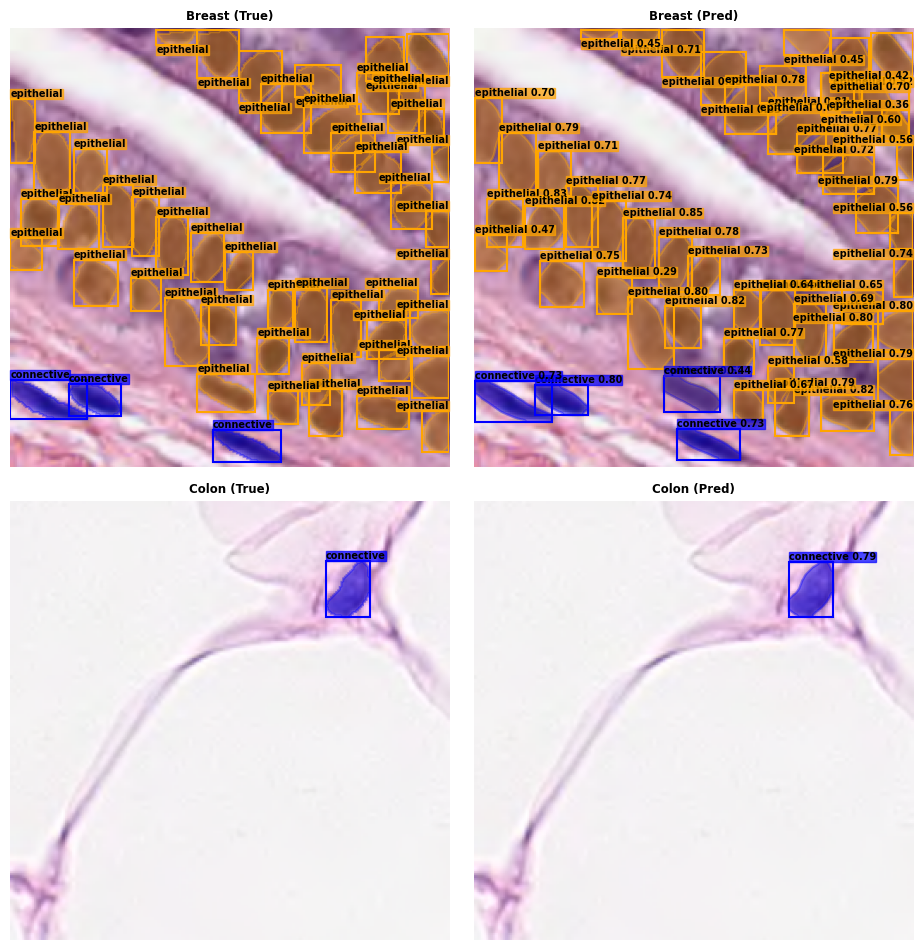

In [47]:
instance_segmentation(val_image_paths)

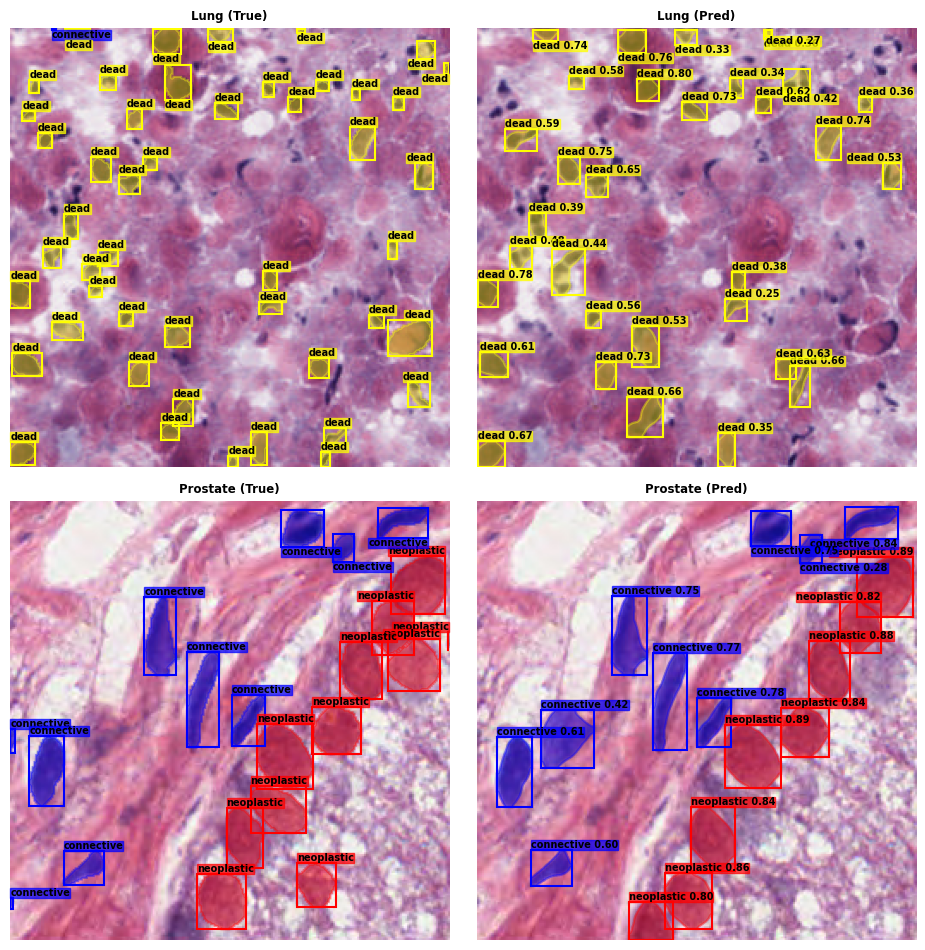

In [48]:
instance_segmentation(val_image_paths)

### **Test Dataset**

In [ ]:
test_image_paths = glob(os.path.join(dataset_dir, "test/images/*.png"))

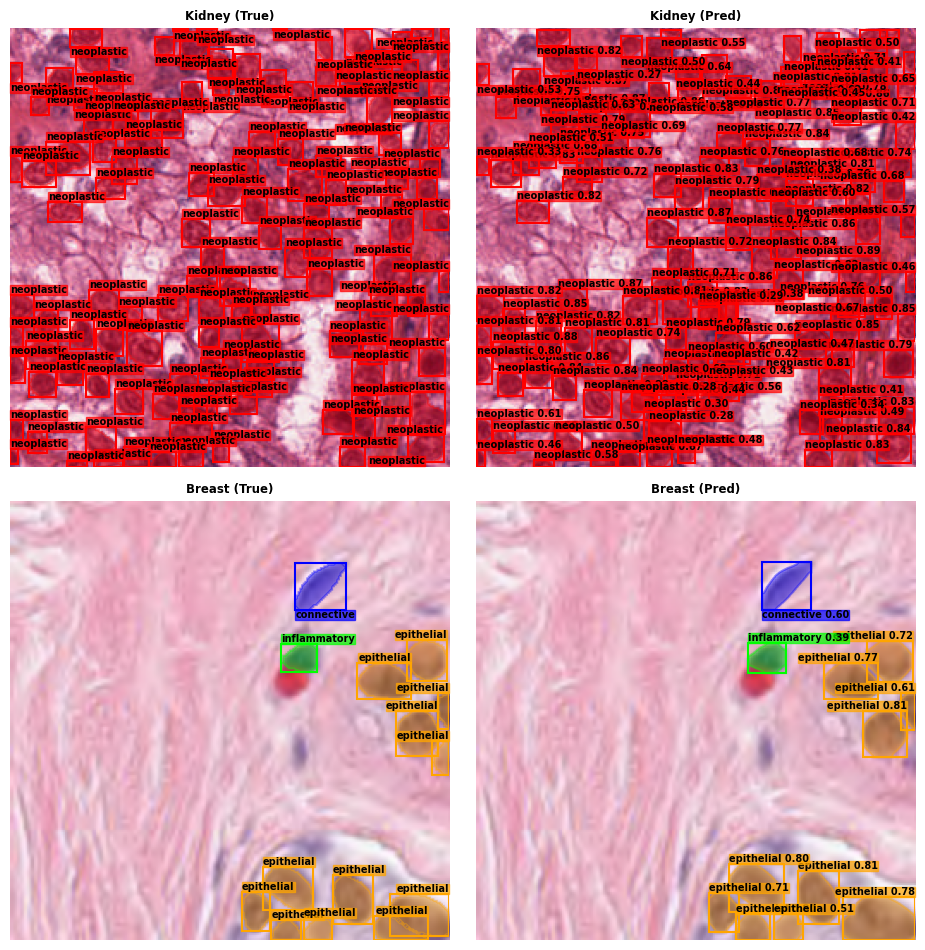

In [58]:
instance_segmentation(test_image_paths)

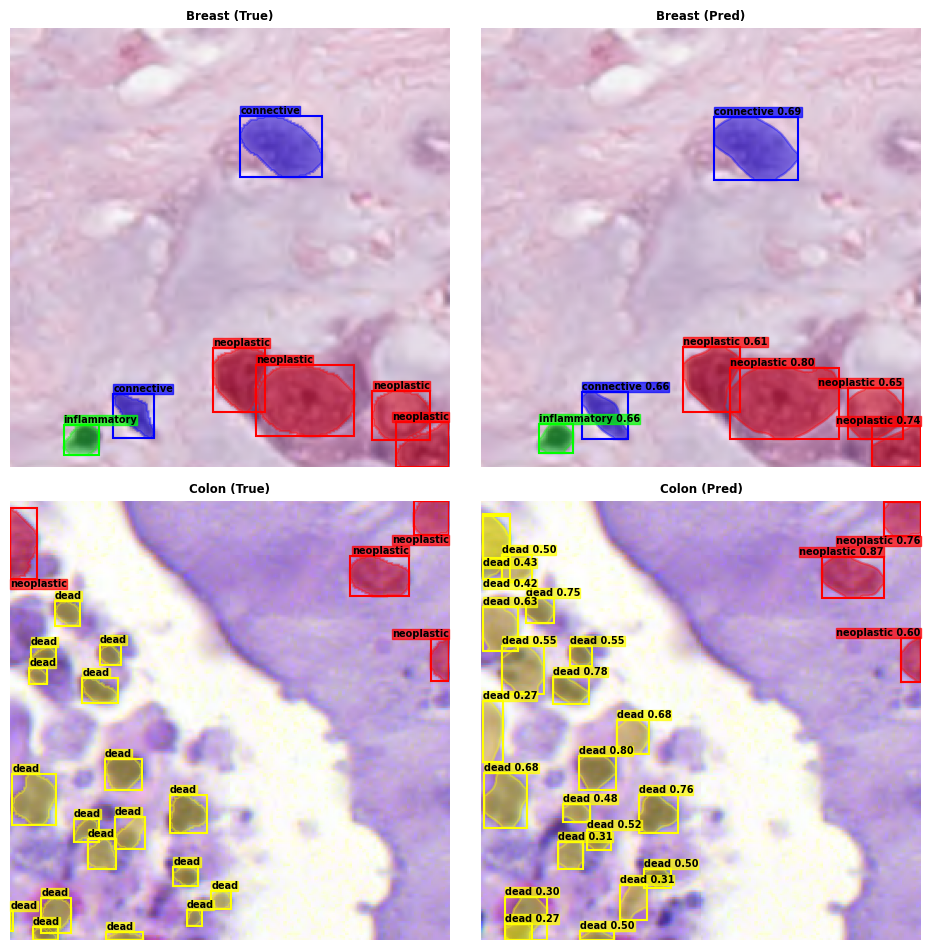

In [51]:
instance_segmentation(test_image_paths)

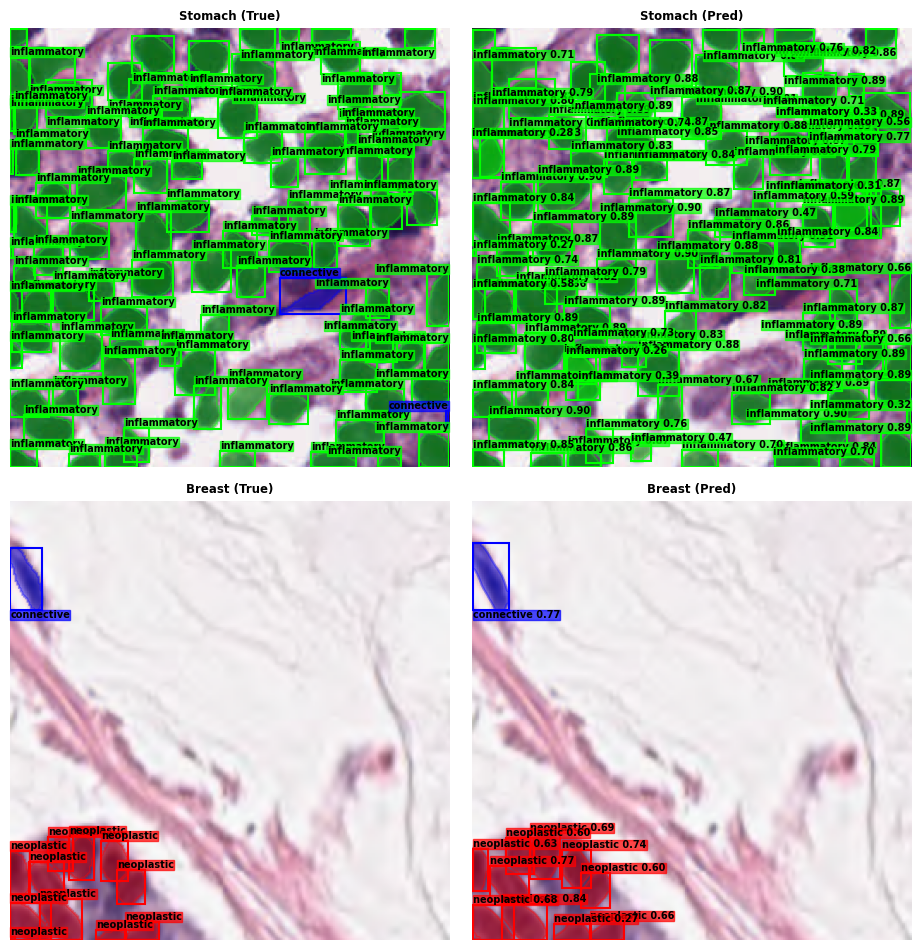

In [57]:
instance_segmentation(test_image_paths)

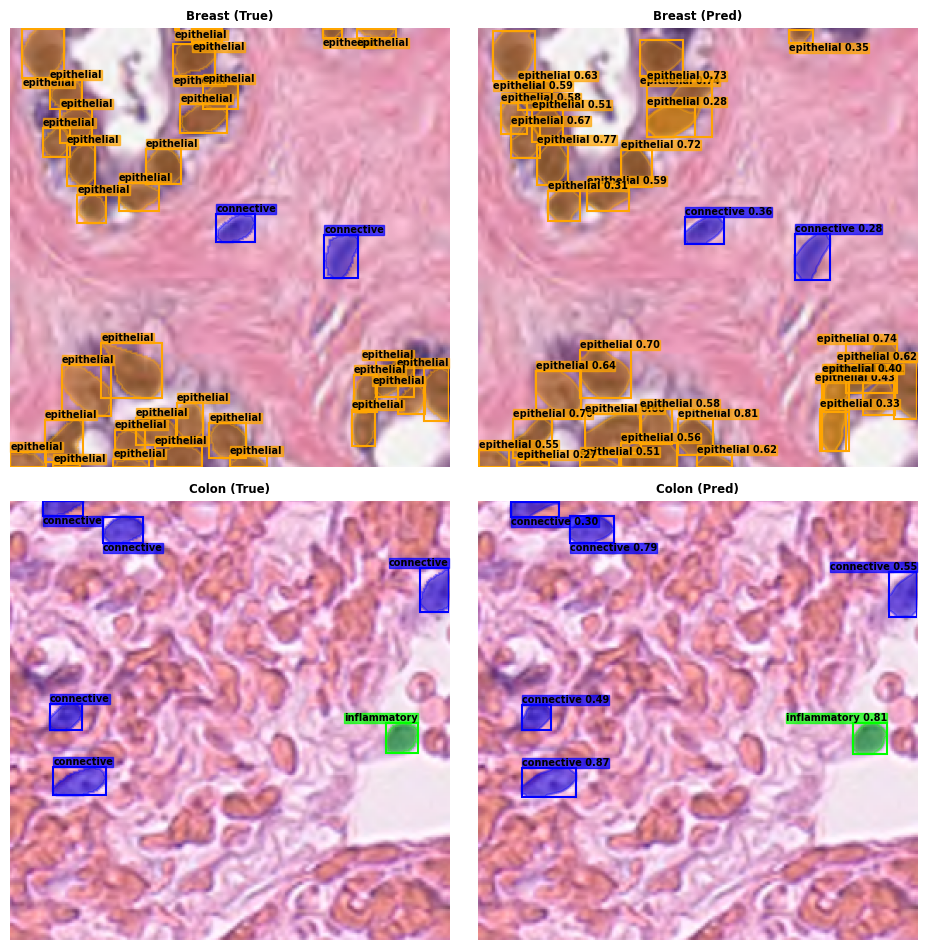

In [53]:
instance_segmentation(test_image_paths)

Since no videos related to the PanNuke dataset were found, video inference cannot be performed. Therefore, a GIF will be created using some of the results from the validation and test sets.

In [59]:
# Function to generate a GIF from a directory of images
def create_gif(gif_path, images_dir, fps=1):
  with imageio.get_writer(gif_path, mode="I", loop=0, fps=fps) as writer:
    image_paths = sorted(glob(os.path.join(images_dir, "*.png")))

    for img_path in image_paths:
      image = imageio.imread(img_path)
      writer.append_data(image)

In [60]:
create_gif("InstanceSegmentation_YOLO11s_PanNuke.gif", "images")

## **Conclusion**

The **YOLO11s-seg** model, fine-tuned with the **PanNuke dataset**, achieved a $\text{mAP}^{\text{mask}}_{50}$ of **0.7** and a $\text{mAP}^{\text{mask}}_{50-95}$ of **0.464** on the validation set, and a $\text{mAP}^{\text{mask}}_{50}$ of **0.692** and a $\text{mAP}^{\text{mask}}_{50-95}$ of **0.455** on the test set. These results indicate **good performance** in instance segmentation of the five cell nucleus classes, although there is still room for improvement. This is expected given the complexity of the **PanNuke** dataset, which, as previously mentioned, contains a limited number of training images, low resolution, and highly similar cell nucleus classes.  

The model performs best on the `neoplastic` and `epithelial` classes in both the validation and test sets, achieving a $\text{mAP}^{\text{mask}}_{50}$ above **0.8**. In contrast, the `dead` class has the lowest performance, with a $\text{mAP}^{\text{mask}}_{50}$ between **0.4** and **0.5**, due to a significant class imbalance in the **PanNuke** dataset, where the `dead` class has considerably fewer instances, as observed during preprocessing.  

To achieve better instance segmentation results, it is essential to improve both the quality and quantity of the images. This would allow the use of larger models than **YOLO11s-seg**, since, as mentioned earlier, with the current dataset, larger models perform worse than **YOLO11s-seg**. Nevertheless, despite these limitations, the model has achieved **remarkably good results** on the **PanNuke** dataset, as demonstrated in the evaluation and inference stages.